In [137]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn


tf.__version__

# https://mapr.com/blog/deep-learning-tensorflow/


'1.5.0'

## connect to DB

In [138]:
DATABASE = 'prodcopy'

if DATABASE == 'prod':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-primary-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }
    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'stage':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-postgres-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '5432',
      'dbname': 'primary_postgres'
    }

    try:
      db_connection = pg.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'prodcopy':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'prodclone.caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }

    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)

## create dataset
- create one dataframe for 10 timepoint for one window
- create many such window-dataframes

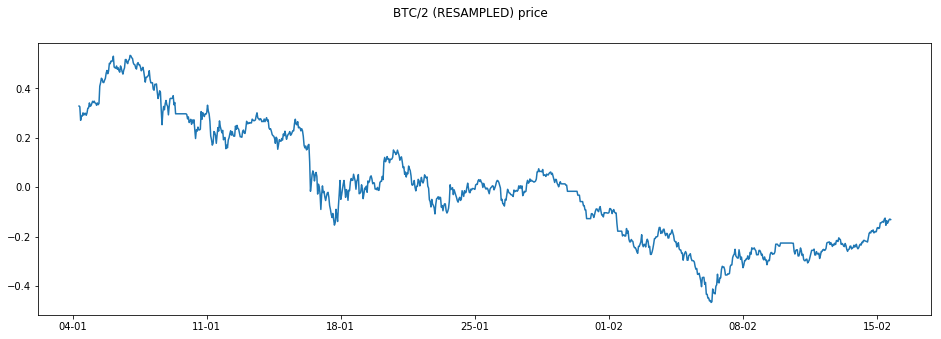

(1018,)


In [139]:
transaction_coin = 'BTC'
counter_coin = 2
resample_period = 60


query = (" SELECT * FROM indicator_priceresampl WHERE \
transaction_currency='%s' AND \
counter_currency=%d \
and resample_period=%d " ) % (transaction_coin, counter_coin, resample_period)

resampl_df = pd.read_sql(query, con=db_connection)
resampl_df['timestamp'] = pd.to_datetime(resampl_df['timestamp'], unit='s')
resampl_df.index = pd.DatetimeIndex(resampl_df.timestamp)
resampl_df.sort_index(inplace=True)

# correct bad resampling
str(int(resample_period/60)) + 'H'
rule = str(int(resample_period/60)) + 'H'
res_df = resampl_df[['high_price','low_price','open_price','close_price']].resample(rule=rule).mean().bfill()

# extract closing price
ts = res_df['close_price']

# normalize
ts = (ts - ts.mean()) / (ts.max() - ts.min())

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("%s/%d (RESAMPLED) price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(ts)
plt.show()
print(ts.shape)


## Convert data into array , break into "batches"

In [140]:
# TODO: this is not correct, we can create a new batch every time we shift data by one!!!
# so we can have much more data

TS = np.array(ts.tail(500))


num_periods = 70  # batch size
f_horizon = 1     # forecast horizon, one period into the future

x_data = TS[:(len(TS) - (len(TS) % num_periods))]   # round th data to periods
print(x_data.shape)
x_batches = x_data.reshape(-1, num_periods, 1)
print(x_batches.shape)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print()
print(y_data.shape)
print(y_batches.shape)

(490,)
(7, 70, 1)

(490,)
(7, 70, 1)


### Create Validation data

In [141]:
TS_valid = np.array(ts.head(500))

def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, 1)
    testY = TS[-(num_periods):].reshape(-1, num_periods, 1)
    return testX,testY

X_test, Y_test = test_data(TS_valid,f_horizon, num_periods )
print(X_test.shape)
print(Y_test.shape)

(1, 70, 1)
(1, 70, 1)


## define layers and Create placeholders

In [144]:
inputs = 1          #number of vectors submitted
hidden = 20          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1          #number of output vectors

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, num_periods, inputs))   #create variable objects
y = tf.placeholder(tf.float32, shape=(None, num_periods, output))

# Define RNN model
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model

training_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)  #train the result of the application of the cost_function                                 



In [145]:


epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
init = tf.global_variables_initializer()           #initialize all the variables

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 500 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})




0 	MSE: 27.7317
500 	MSE: 0.0982564


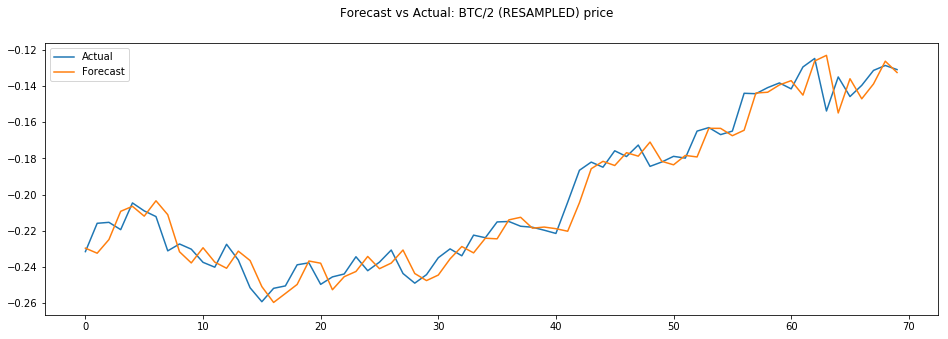

In [146]:


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("Forecast vs Actual: %s/%d (RESAMPLED) price" % (transaction_coin, counter_coin))

ax1.plot(pd.Series(np.ravel(Y_test)),  markersize=2, label="Actual")
ax1.plot(pd.Series(np.ravel(y_pred)),  markersize=1, label="Forecast")
plt.legend(loc="upper left")
plt.show()


In [60]:
y_pred.shape


(1, 20, 1)